In [357]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from pathlib import Path

### Merging evaluation systems results

In [358]:
statistics_path = os.path.join(os.sep, "home", "data")

query_statistics_output_file  = os.path.join(statistics_path, "query_statistics.csv")
ingestion_statistics_output_file = os.path.join(statistics_path, "ingestion_statistics.csv")

figures_path = os.path.join(os.sep, "home", "figures")

In [359]:
for path in (query_statistics_output_file, ingestion_statistics_output_file):
    Path(path).unlink(missing_ok=True)

ingestion_statistics = pd.DataFrame()
query_statistics = pd.DataFrame()

# Aggregate different systems results

for evaluated_system in os.listdir(statistics_path):
    if os.path.isdir(os.path.join(statistics_path, evaluated_system)):
        ingestion_file = os.path.join(statistics_path, evaluated_system, "ingestion_time","ingestion_statistics.csv")
        query_file = os.path.join(statistics_path, evaluated_system, "query_evaluation","statistics.csv")
        if os.path.exists(ingestion_file):
            ingestion_statistics = pd.concat([ingestion_statistics, pd.read_csv(ingestion_file)], ignore_index=True)
        query_statistics = pd.concat([query_statistics, pd.read_csv(query_file)], ignore_index=True)

ingestion_statistics["datasetSize"] = ingestion_statistics["datasetSize"].apply(lambda x: str.capitalize(x))
query_statistics["datasetSize"] = query_statistics["datasetSize"].apply(lambda x: str.capitalize(x))

ingestion_statistics.to_csv(ingestion_statistics_output_file, index=False )
query_statistics.to_csv(query_statistics_output_file, index=False )

In [360]:
# Delete old statistics
for path in (query_statistics_output_file, ingestion_statistics_output_file):
    Path(path).unlink(missing_ok=True)

ingestion_statistics = pd.DataFrame()
query_statistics = pd.DataFrame()

# Aggregate different systems results

for evaluated_system in os.listdir(statistics_path):
    if os.path.isdir(os.path.join(statistics_path, evaluated_system)):
        ingestion_file = os.path.join(statistics_path, evaluated_system, "ingestion_time","ingestion_statistics.csv")
        query_file = os.path.join(statistics_path, evaluated_system, "query_evaluation","statistics.csv")
        if evaluated_system == "pgage":
            pgage = pd.read_csv(ingestion_file)
            # pgage['iteration'] = range(1, len(pgage) + 1)
            # pgage["startTimestamp"] = round(pgage["startTimestamp"]/10,0)
            # pgage["endTimestamp"] = round(pgage["endTimestamp"]/10,0)
            # pgage["graphElapsedTime"] = round(pgage["graphElapsedTime"] * 1000,0)
            # pgage["tsElapsedTime"] = round(pgage["tsElapsedTime"] * 1000,0)
            # pgage["elapsedTime"] = round(pgage["elapsedTime"] * 1000,0)
            # pgage.to_csv(ingestion_file, index=False)
        # query = pd.read_csv(query_file)
        # query.drop(columns=["iteration"], inplace=True)
        # query["temporalRangeIndex"] = 0
        # if (query["model"] == "STGraph").all():
        #     query = add_iteration_column(query, ["model","dataset","datasetSize","queryName","threads","queryType","querySelectivity","numMachines"])
        # else:
        #     query = add_iteration_column(query, ["test_id","model","dataset","datasetSize","threads","queryName","queryType","querySelectivity","numMachines"])
        # query.to_csv(query_file, index=False)
        if os.path.exists(ingestion_file):
            ingestion_statistics = pd.concat([ingestion_statistics, pd.read_csv(ingestion_file)], ignore_index=True)
        query_statistics = pd.concat([query_statistics, pd.read_csv(query_file)], ignore_index=True)

ingestion_statistics["datasetSize"] = ingestion_statistics["datasetSize"].apply(lambda x: str.capitalize(x))
query_statistics["datasetSize"] = query_statistics["datasetSize"].apply(lambda x: str.capitalize(x))

ingestion_statistics.to_csv(ingestion_statistics_output_file, index=False )
query_statistics.to_csv(query_statistics_output_file, index=False )

Utils

In [361]:
query_names = {
    "EnvironmentCoverage": "Q1",
    "EnvironmentAggregate": "Q2",
    "MaintenanceOwners": "Q3",
    "EnvironmentAlert": "Q4",
    "EnvironmentOutlier": "Q4",
    "AgentOutlier": "Q5",
    "AgentHistory": "Q6"
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
patterns = ['solid', '...', '///', '/', '|', '-', '+', 'x', 'o', 'O', '.', '*']              # hatch patterns for consistency

## Generating figures

Utility functions

In [362]:
def print_ingestion_statistics(ingestion_statistics: pd.DataFrame):
    """
    Print ingestion statistics bar plot (log scale, clipped values, scalable patterns).
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import os

    # Copy dataframe
    df = ingestion_statistics.copy(deep=True)
    df = df[df["threads"] == 1]

    # Group by datasetSize and model
    grouped = df.groupby(["datasetSize", "model"])["elapsedTime"].mean().reset_index()

    # Dataset order
    dataset_order = ["Small", "Large", "Big"]
    grouped["datasetSize"] = pd.Categorical(grouped["datasetSize"], categories=dataset_order, ordered=True)

    # All models
    all_models = sorted(grouped["model"].unique())

    # Colors and scalable patterns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Plot parameters
    bar_width = 0.15  # ridotto rispetto a prima
    x = np.arange(len(dataset_order))

    fig, ax = plt.subplots(figsize=(12, 6))  # figura più larga

    CLIP_VALUE = 1e8

    # Draw bars
    for i, model in enumerate(all_models):
        for j, ds in enumerate(dataset_order):
            subset = grouped[(grouped["datasetSize"] == ds) & (grouped["model"] == model)]
            value = subset["elapsedTime"].values[0] if not subset.empty else np.nan
            display_value = min(value, CLIP_VALUE)

            ax.bar(
                x[j] + i * bar_width,
                display_value,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                hatch=patterns[i],
                label=model if j == 0 else None
            )

            # Label for clipped bars
            if value > CLIP_VALUE:
                ax.text(
                    x[j] + i * bar_width + bar_width * 0.6,
                    CLIP_VALUE * 1.2,
                    f"{value:.2e}",
                    va='bottom',
                    ha='left',
                    fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.85, pad=1.5)
                )

    # X axis
    ax.set_xticks(x + bar_width * (len(all_models)/2))
    ax.set_xticklabels(dataset_order)
    ax.set_xlabel("Dataset Size")

    # Y axis log scale
    ax.set_yscale("log")
    ax.set_ylim(1e3, 10**8.4)
    ax.set_ylabel("Avg. Elapsed Time (ms)")
    ax.tick_params(axis='y', which='both', length=0)
    ax.grid(True, which="major", axis="y", linewidth=0.3)

    # Legend handles
    handles = [
        mpatches.Patch(facecolor=colors[i % len(colors)],
                       hatch=patterns[i],
                       edgecolor='black',
                       label=model)
        for i, model in enumerate(all_models)
    ]

    fig.legend(
        handles=handles,
        loc='upper center',
        ncol=len(all_models),
        frameon=False,
        bbox_to_anchor=(0.5, 0.92),
        fontsize=14
    )

    plt.subplots_adjust(top=0.85, wspace=0.3)

    # Save figure
    plt.savefig(os.path.join(figures_path, "ingestion_statistics.svg"), format='svg', bbox_inches='tight')
    plt.show()


def plot_execution_times_selectivity(df, dataset_size, threads):
    """
    Plot line charts of average execution times per temporal range coverage (%).

    Parameters:
    - df: pandas DataFrame containing the dataset
    - dataset_size: str, e.g., 'large' or 'small', filter dataset
    - threads: int, number of threads to filter
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Map temporalRangeIndex to coverage percentage (0=100%, 9=10%)
    max_index = 9
    coverage_map = {i: round((i + 1) * 10, 1) for i in range(0, max_index+1)}

    # Map query names
    query_names = {
        "EnvironmentCoverage": "Q1",
        "EnvironmentAggregate": "Q2",
        "MaintenanceOwners": "Q3",
        "EnvironmentAlert": "Q4",
        "EnvironmentOutlier": "Q4",
        "AgentOutlier": "Q5",
        "AgentHistory": "Q6"
    }

    # Filter dataframe by dataset size, threads, and remove unwanted queries
    df_filtered = df[
        (df['datasetSize'] == dataset_size) &
        (df['threads'] == threads)
    ]

    # Apply query name mapping
    df_filtered['queryName'] = df_filtered['queryName'].map(query_names)

    # Get unique queries and models
    queries = sorted(df_filtered['queryName'].unique())
    models = sorted(df_filtered['model'].unique())

    num_queries = len(queries)
    ncols = (num_queries + 1) // 2
    nrows = 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 5*nrows), sharey=True)
    axes = axes.flatten()

    for i, query in enumerate(queries):
        ax = axes[i]
        df_query = df_filtered[df_filtered['queryName'] == query]

        for model in models:
            df_model = df_query[df_query['model'] == model]

            # Calculate mean elapsedTime per temporalRangeIndex
            mean_times = df_model.groupby('temporalRangeIndex')['elapsedTime'].mean()

            # Map temporalRangeIndex to coverage %
            coverage_x = [coverage_map[idx] for idx in mean_times.index]

            ax.plot(
                coverage_x,
                mean_times.values,
                marker='o',
                label=model
            )

        ax.set_title(f"{query}")
        ax.set_xlabel("Temporal Range Coverage (%)")
        ax.set_ylabel("Mean Elapsed Time (ms)")
        ax.set_xticks([10,20,30,40,50,60,70,80,90,100])
        ax.grid(True)
        ax.legend()

    # Remove empty subplots if queries < nrows*ncols
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, "query_selectivity.svg"), format='svg', bbox_inches='tight')
    plt.show()

def print_query_statistics(query_statistics: pd.DataFrame, name="query_statistics"):
    # --- Copy and preprocess ---
    query_df = query_statistics.copy(deep=True)
    query_df = query_df[query_df["datasetSize"] != "big_long"]

    # Map query names to query IDs
    query_df["queryID"] = query_df["queryName"].map(query_names)

    # Fixed dataset sizes
    dataset_sizes = ["Small", "Large", "Big"]

    # Create figure
    fig, axes = plt.subplots(
        1,
        len(dataset_sizes),
        figsize=(6 * len(dataset_sizes), 4)
    )

    if len(dataset_sizes) == 1:
        axes = [axes]

    # Plot parameters
    all_models = sorted(query_df["model"].unique())
    num_models = len(all_models)
    bar_width = min(0.8 / num_models, 0.18)

    # --- Plot per dataset size ---
    for ax, ds in zip(axes, dataset_sizes):
        df_filtered = query_df[
            (query_df["threads"] == 1) &
            (query_df["datasetSize"] == ds)
        ]

        grouped = (
            df_filtered
            .groupby(["queryID", "model"])["elapsedTime"]
            .mean()
            .reset_index()
        )

        query_ids = grouped["queryID"].unique()
        x = np.arange(len(query_ids))

        for i, model in enumerate(all_models):
            values = [
                grouped[
                    (grouped["queryID"] == q) &
                    (grouped["model"] == model)
                ]["elapsedTime"].values[0]
                if not grouped[
                    (grouped["queryID"] == q) &
                    (grouped["model"] == model)
                ].empty
                else np.nan
                for q in query_ids
            ]

            offset = (i - (num_models - 1) / 2) * bar_width

            ax.bar(
                x + offset,
                values,
                width=bar_width,
                color=colors[i],
                edgecolor="black",
                hatch=patterns[i]
            )

        # X axis
        ax.set_xticks(x)
        ax.set_xticklabels(query_ids)
        ax.set_xlabel("Query ID")

        # Y axis
        ax.set_yscale("log")
        ax.set_ylim(1, 1e8)
        ax.set_ylabel("Latency (ms)")
        ax.tick_params(axis="y", which="both", length=0)

        # Title and grid
        ax.set_title(f"Dataset Size: {ds}")
        ax.grid(True, which="both", axis="y", linewidth=0.3)
        ax.margins(x=0.05)

    # --- Legend ---
    handles = [
        mpatches.Patch(
            facecolor=colors[i],
            hatch=patterns[i],
            edgecolor="black",
            label=model
        )
        for i, model in enumerate(all_models)
    ]

    fig.legend(
        handles=handles,
        loc="upper center",
        ncol=num_models,
        frameon=False,
        bbox_to_anchor=(0.5, 0.92),
        fontsize=14
    )

    # Layout and save
    plt.subplots_adjust(top=0.7, wspace=0.3)
    plt.savefig(
        os.path.join(figures_path, f"{name}.svg"),
        format="svg",
        bbox_inches="tight"
    )
    plt.show()


Ingestion statistics

/tmp/ipykernel_49762/2475257670.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_49762/2475257670.py:79: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor=colors[i % len(colors)],


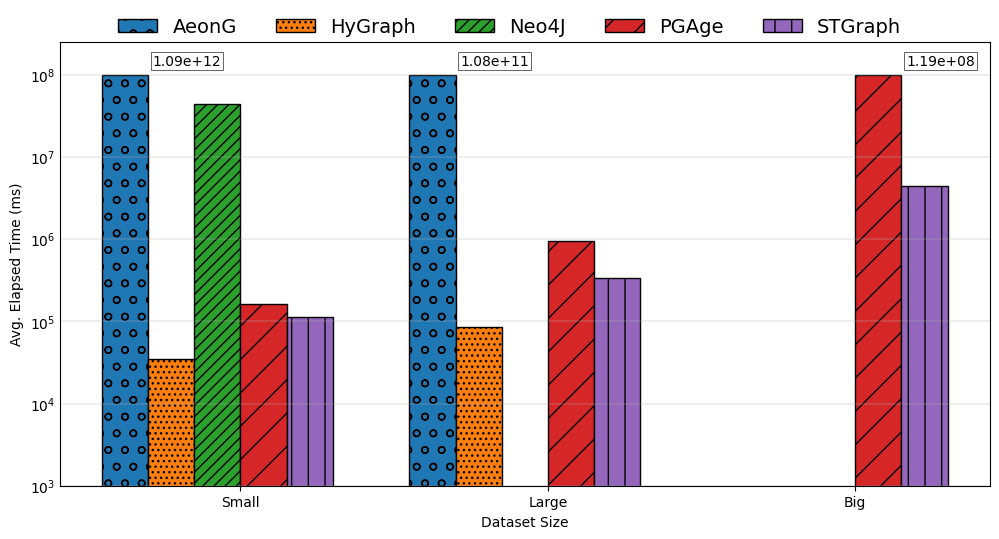

In [363]:
print_ingestion_statistics(ingestion_statistics)

Query statistics - <b>different</b> selectivity across dataset size

/tmp/ipykernel_49762/2475257670.py:243: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_49762/2475257670.py:243: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_49762/2475257670.py:243: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_49762/2475257670.py:270: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is depre

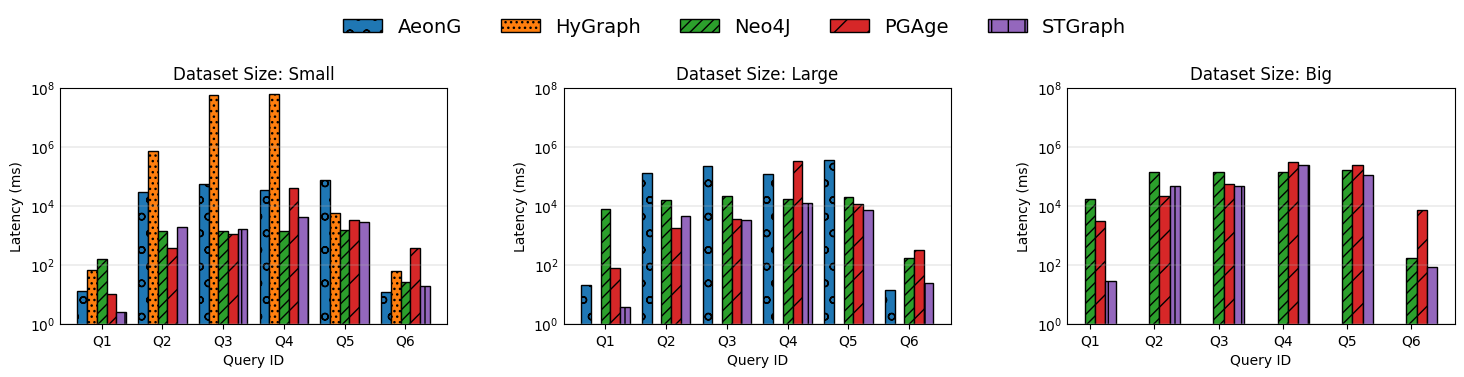

In [364]:
query_statistics_different_selectivity = query_statistics.loc[query_statistics["querySelectivity"] == "increased"]
print_query_statistics(query_statistics_different_selectivity, "query_statistics_increased")

In [365]:
query_statistics_different_selectivity = query_statistics_different_selectivity.loc[((query_statistics_different_selectivity["model"] == "STGraph") | (query_statistics_different_selectivity["model"] == "PGAge")) & (query_statistics_different_selectivity["datasetSize"] == "Big")]
query_statistics_different_selectivity.groupby(by=["queryName", "model"]).agg({"elapsedTime": "mean"})

elapsedTime
queryName            model                 
AgentHistory         PGAge      6946.162500
                     STGraph      86.214286
AgentOutlier         PGAge    248474.622000
                     STGraph  106459.571429
EnvironmentAggregate PGAge     21751.338000
                     STGraph   48035.923077
EnvironmentCoverage  PGAge      2952.172500
                     STGraph      28.076923
EnvironmentOutlier   PGAge    294772.324000
                     STGraph  231440.846154
MaintenanceOwners    PGAge     55860.412500
                     STGraph   47639.307692

/tmp/ipykernel_49762/1698004628.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['queryName'] = df_filtered['queryName'].map(query_names)


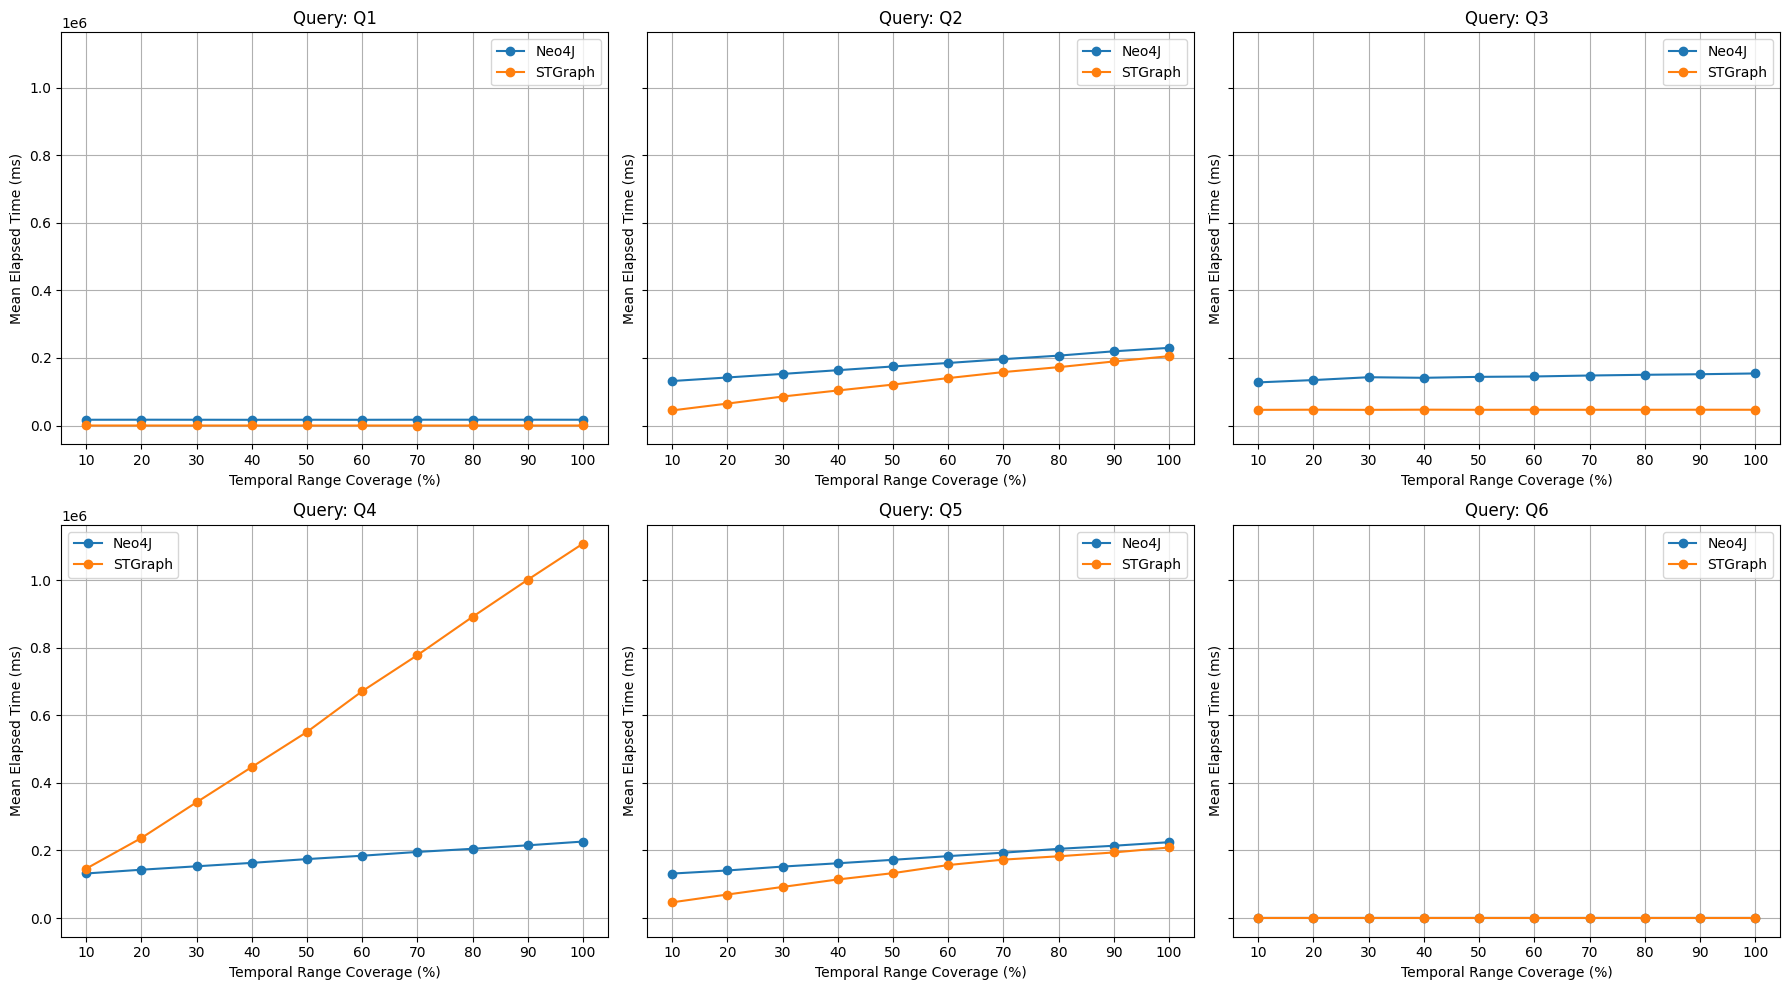

In [366]:
quer_dset = query_statistics.loc[query_statistics["querySelectivity"] == "scaled"]
plot_execution_times(quer_dset, "Big", 1)

Evaluating performances w.r.t. query selectivity

/tmp/ipykernel_49762/1698004628.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['queryName'] = df_filtered['queryName'].map(query_names)


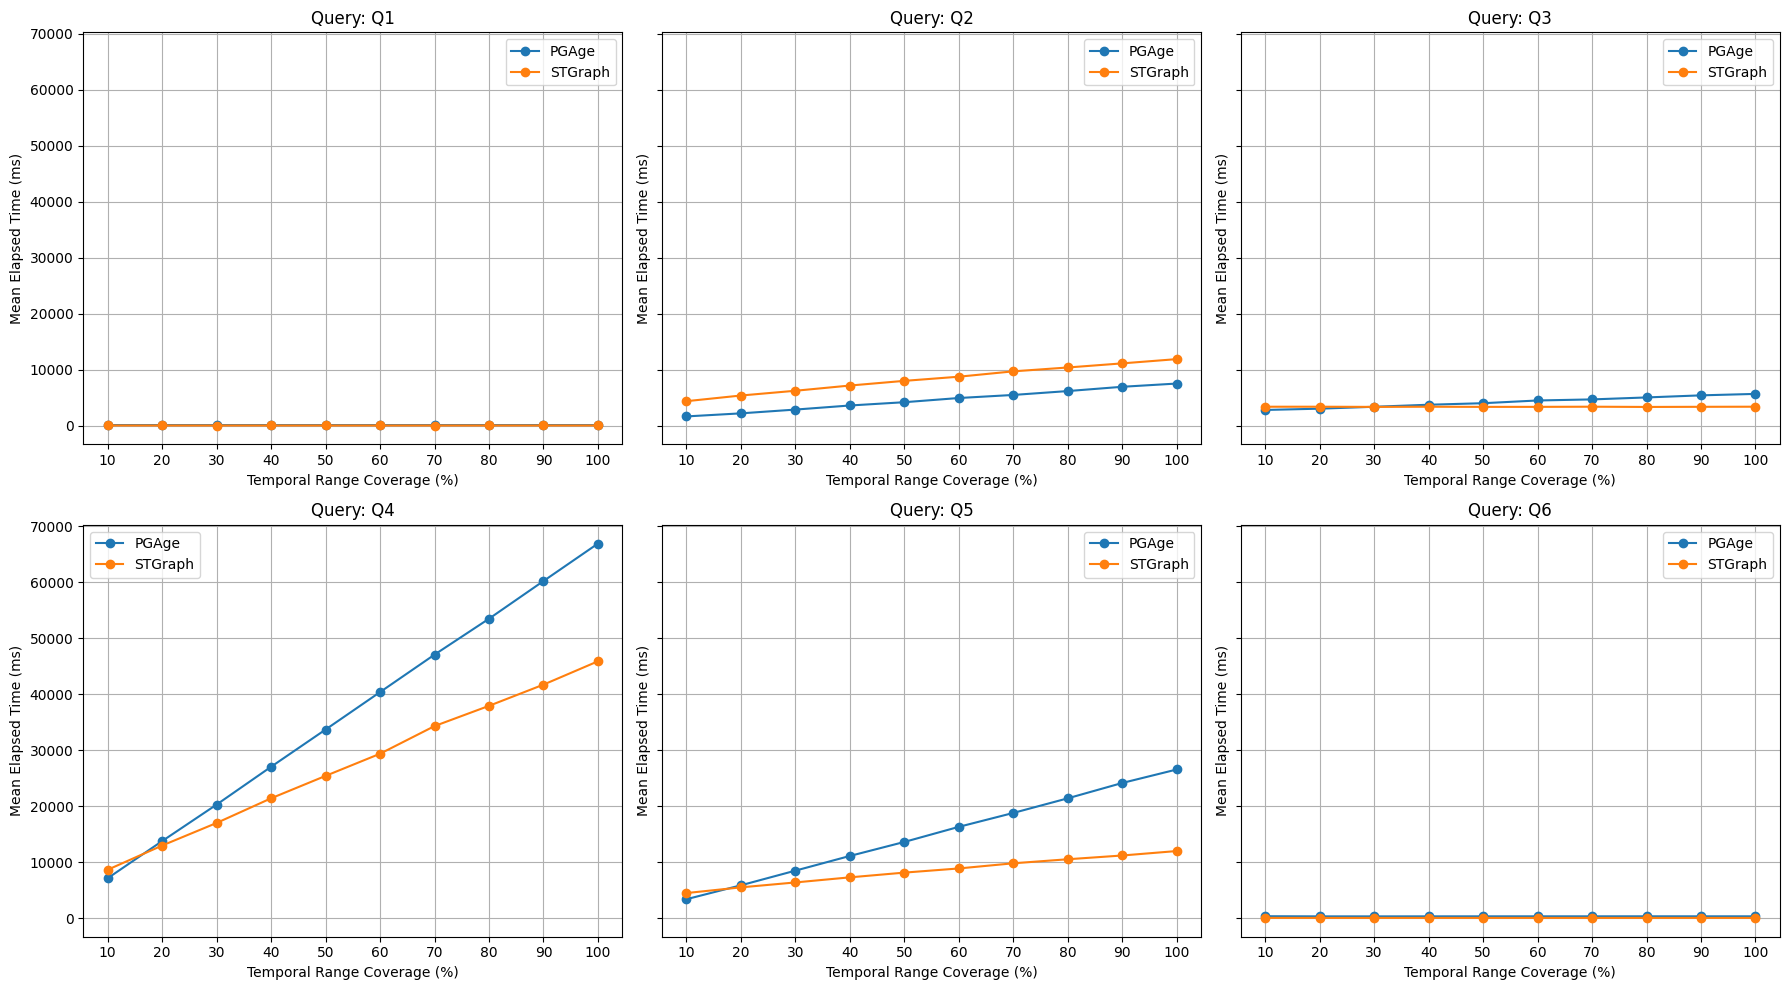

In [367]:
quer_dset = query_statistics.loc[query_statistics["querySelectivity"] == "scaled"]
plot_execution_times(quer_dset, "Large", 1)

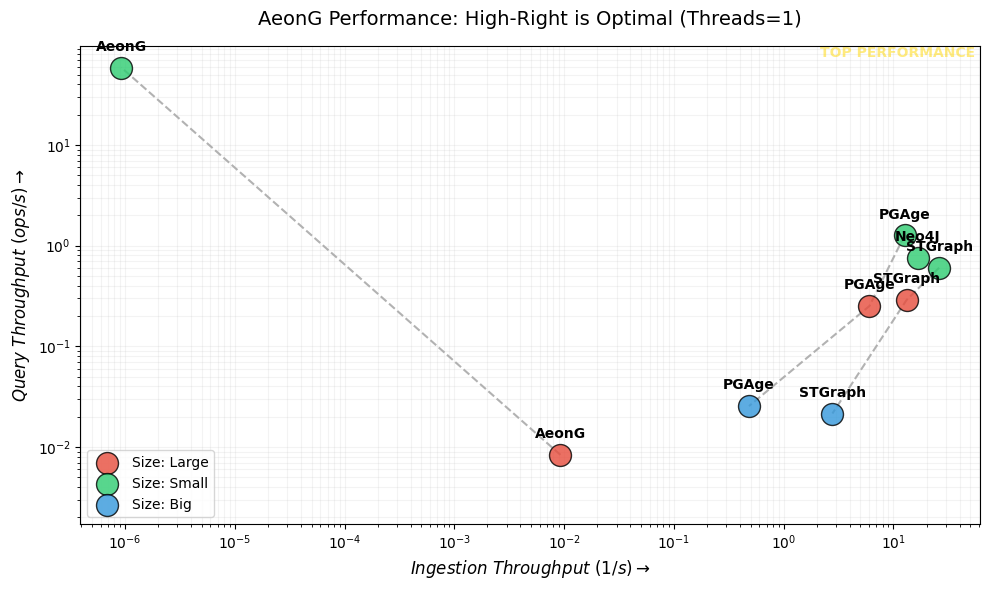

In [ ]:
def plot_performance_inverse_tradeoff(df_queries, df_ingestion):
    """
    Genera un grafico dove l'asse X è il throughput di ingestion (archi/s)
    e l'asse Y è il throughput delle query (ops/s).
    In alto a destra = Performance Migliori.
    """
    # 1. Copia e normalizzazione
    q = df_queries.copy()
    i = df_ingestion.copy()
    
    for df in [q, i]:
        df['model'] = df['model'].astype(str).str.strip()
        df['datasetSize'] = df['datasetSize'].astype(str).str.strip()

    # 2. Filtro lock su threads = 1
    q = q[q['threads'] == 1]
    i = i[i['threads'] == 1]

    if q.empty or i.empty:
        print("Dati insufficienti per il filtro threads=1.")
        return

    # 3. Aggregazione
    q_agg = q.groupby(['model', 'datasetSize'])['elapsedTime'].median().reset_index()
    i_agg = i.groupby(['model', 'datasetSize'])['graphElapsedTime'].mean().reset_index()

    # 4. Merge
    df_plot = pd.merge(q_agg, i_agg, on=['model', 'datasetSize'])
    
    # 5. Trasformazione in THROUGHPUT (Inverse)
    # Assumendo graphElapsedTime in microsecondi per il calcolo del throughput
    # Se graphElapsedTime è il tempo totale, il throughput è proporzionale a 1/tempo
    df_plot['ingestion_throughput'] = 1_000_000 / df_plot['elapsedTime'] 
    df_plot['query_throughput'] = 1000 / df_plot['elapsedTime']

    # 6. Plotting
    plt.figure(figsize=(10, 6))
    colors = {'Small': '#2ecc71', 'Large': '#e74c3c'}

    for size in df_plot['datasetSize'].unique():
        subset = df_plot[df_plot['datasetSize'] == size]
        
        plt.scatter(
            subset['ingestion_throughput'], 
            subset['query_throughput'], 
            s=250, 
            c=colors.get(size, '#3498db'),
            label=f"Size: {size}",
            alpha=0.8, 
            edgecolors='black',
            zorder=3
        )

    # Linea che unisce i punti dello stesso modello per vedere il "decadimento"
    for model in df_plot['model'].unique():
        m_subset = df_plot[df_plot['model'] == model].sort_values('ingestion_throughput', ascending=False)
        plt.plot(m_subset['ingestion_throughput'], m_subset['query_throughput'], 
                 'k--', alpha=0.3, zorder=1)

    # Annotazioni
    for _, row in df_plot.iterrows():
        plt.annotate(
            row['model'], 
            (row['ingestion_throughput'], row['query_throughput']),
            textcoords="offset points", xytext=(0, 12), ha='center', fontweight='bold'
        )

    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel(r'$Ingestion\ Throughput\ (1/s) \rightarrow$', fontsize=12)
    plt.ylabel(r'$Query\ Throughput\ (ops/s) \rightarrow$', fontsize=12)
    plt.title('AeonG Performance: High-Right is Optimal (Threads=1)', fontsize=14, pad=15)
    
    plt.grid(True, which="both", ls="-", alpha=0.15)
    plt.legend()
    
    # Area "Performance Top"
    plt.text(plt.xlim()[1], plt.ylim()[1], 'TOP PERFORMANCE ', 
             verticalalignment='top', horizontalalignment='right', 
             color='gold', fontweight='bold', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Esecuzione
plot_performance_inverse_tradeoff(query_statistics, ingestion_statistics)
# plot_performance_tradeoff('query.csv', 'ingestion.csv')
# Esempio di utilizzo:

### STGraph - Scale Out

Ingestion stats

   numMachines  graphElapsedTime  tsElapsedTime
0            2      83512.600000   1.038752e+07
1            4     109115.862745   5.559638e+06
2            8     134872.454545   3.425224e+06


/tmp/ipykernel_722/2101256888.py:37: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/2101256888.py:65: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],


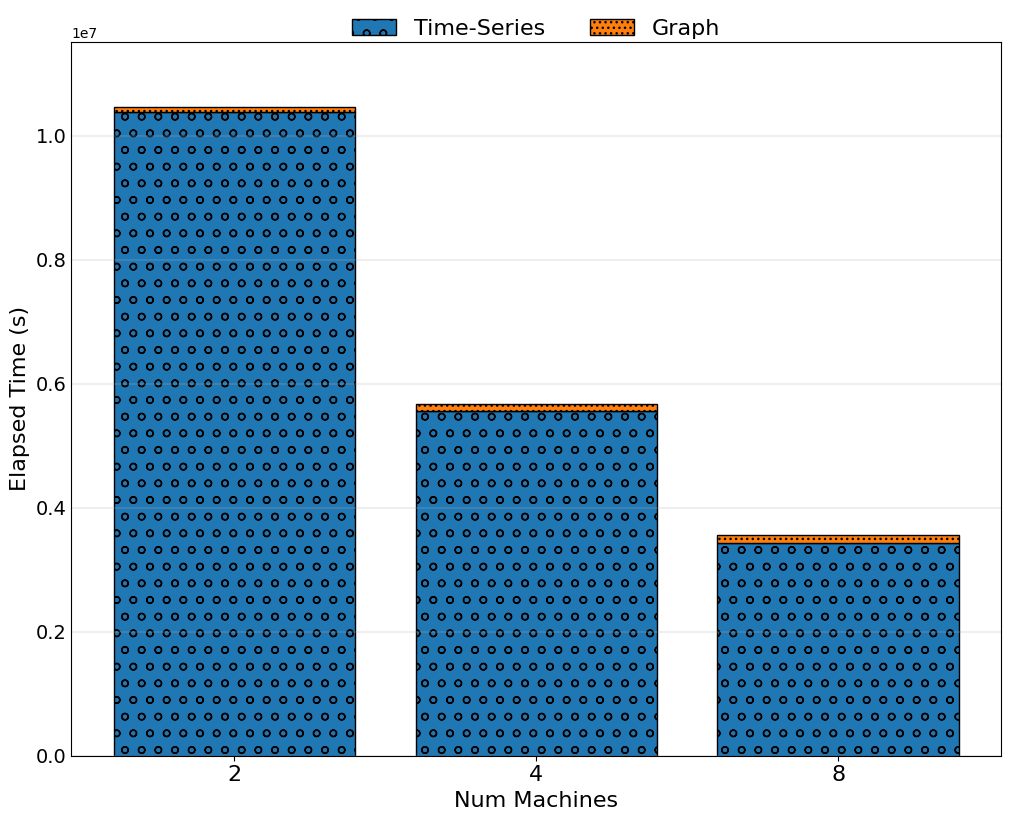

In [ ]:
def plot_stacked_elapsed_times(df, model_filter, threads_filter, dataset_filter):
    """  
    Build a stacked bar chart similar to the Tableau screenshot, using a consistent style.  

    Parameters:  
    - df: pandas DataFrame containing columns:  
        ['model', 'threads', 'datasetSize', 'numMachines', 'graphElapsedTime', 'tsElapsedTime']  
    - model_filter: str, e.g. 'STGraph'  
    - threads_filter: int, e.g. 1  
    - dataset_filter: str, e.g. 'big_long'  
    - unit: 'ms', 's', or 'min' (default 'ms')  
    """  


    # Filter data according to model, threads, and dataset size  
    filtered = df[  
        (df["model"] == model_filter) &  
        (df["threads"] == threads_filter) &  
        (df["datasetSize"] == dataset_filter)  
    ]  

    # Group by number of machines and compute the mean elapsed times  
    grouped = filtered.groupby("numMachines")[["graphElapsedTime", "tsElapsedTime"]].mean().reset_index()  
    grouped = grouped.sort_values("numMachines")  

    print(grouped)

    # Discrete x positions for compact bars  
    x = np.arange(len(grouped))  

    # Create figure and axes  
    fig, ax = plt.subplots(figsize=(12, 6))  

    # Draw stacked bars  
    bottom = np.zeros(len(grouped))  
    for i, col in enumerate(["tsElapsedTime", "graphElapsedTime"]):  
        ax.bar(  
            x,  
            grouped[col],  
            bottom=bottom,  
            color=colors[i],  
            edgecolor='black',  
            hatch=patterns[i],  
            label=col.replace("ElapsedTime", " Latency")
        )
        bottom += grouped[col].values

    # Set X-axis labels only for actual number of machines
    ax.set_xticks(x)
    ax.set_xticklabels(grouped["numMachines"], fontsize=16)
    ax.set_xlabel("Num Machines", fontsize=16)

    # ax.set_yscale("log")

    # Y-axis – linear scale with extra space above maximum
    ax.set_ylabel(f"Elapsed Time (s)", fontsize=16)
    ax.set_ylim(0, bottom.max() * 1.1)
    ax.tick_params(axis='y', which='both', length=0,labelsize=14,)  # remove tick lines

    # Horizontal grid lines for reference
    ax.grid(True, axis="y", linewidth=0.3)

    # Custom legend for stacked bars
    handles = [
        mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],
                       label=col.replace("ElapsedTime", " Latency"))
        for i, col in enumerate(["Time-Series", "Graph"])
    ]
    ax.legend(handles=handles, loc='upper center', ncol=2, frameon=False,
              bbox_to_anchor=(0.5, 1.06), fontsize=16)

    # Adjust layout and save figure as SVG
    plt.subplots_adjust(top=1.3, wspace=0.3)
    plt.savefig(os.path.join(figures_path, f"scaleout_ingestion_statistics.svg"), format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage:
plot_stacked_elapsed_times(ingestion_statistics.loc[ingestion_statistics["numMachines"] > 1], "STGraph", 16, "Big_long")


Query Latency

2 machines -> [np.float64(45648.76666666667), np.float64(9506.833333333334), np.float64(293696.1666666667), np.float64(47680.8)]
4 machines -> [np.float64(28419.166666666668), np.float64(10230.016666666666), np.float64(167119.61666666667), np.float64(29613.25)]
8 machines -> [np.float64(17918.866666666665), np.float64(11416.733333333334), np.float64(80083.46666666666), np.float64(20084.633333333335)]


/tmp/ipykernel_722/3686497003.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(


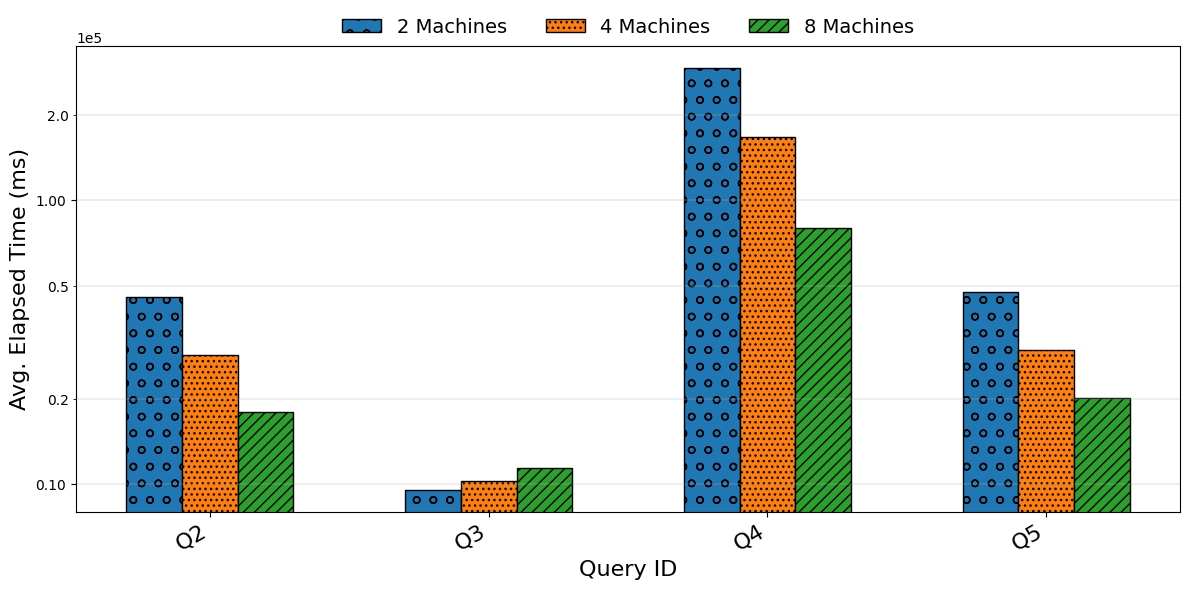

In [ ]:
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter

# Copy dataframe
df = query_statistics.copy(deep=True)
df = df.loc[(query_statistics["queryName"] != "AgentHistory") & (query_statistics["queryName"] != "EnvironmentCoverage")]
df["queryID"] = df["queryName"].apply(lambda row: query_names[row])
# Filter as in Tableau dashboard
df = df[
    (df["threads"] == 16) &
    (df["datasetSize"] == "Big_long") &
    (df["model"] == "STGraph")
]

# Compute mean elapsed time grouped by Query Name and Num Machines
grouped = (
    df.groupby(["queryID", "numMachines"])["elapsedTime"]
    .mean()
    .reset_index()
)

# Sort query names consistently
query_names_sorted = sorted(grouped["queryID"].unique())

# Sort numMachines as numeric order (2,4,8,...)
machines_sorted = sorted(grouped["numMachines"].unique())

# X positions
x = np.arange(len(query_names_sorted))
bar_width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))

# Draw bars
for i, m in enumerate(machines_sorted):
    # Values for each query
    values = [
        grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)]["elapsedTime"].values[0]
        if not grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)].empty
        else np.nan
        for q in query_names_sorted
    ]
    print(f"{m} machines ->", list(values))
    ax.bar(
        x + i * bar_width,
        values,
        width=bar_width,
        color=colors[i % len(colors)],
        edgecolor='black',
        hatch=patterns[i % len(patterns)],
        label=f"{m} Machines"
    )

# X-axis
ax.set_xticks(x + bar_width * (len(machines_sorted)-1) / 2)
ax.set_xticklabels(query_names_sorted, rotation=30, ha='right', fontsize=16)
ax.set_xlabel("Query ID", fontsize=16)

# Y-axis
ax.set_ylabel("Avg. Elapsed Time (ms)", fontsize=16)
ax.set_yscale("log")

# Major ticks = potenze di 10
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))

ax.yaxis.set_minor_locator(LogLocator(base=10.0,
                                      subs=[1,2,5],
                                      numticks=50))

sf = ScalarFormatter()
sf.set_scientific(True)        # forza notazione scientifica
sf.set_powerlimits((0,0))      # forza esponente per tutti i valori
ax.yaxis.set_major_formatter(sf)
ax.yaxis.set_minor_formatter(sf)

# Grid
ax.grid(True, which="both", axis="y", linewidth=0.3)

# Legend
ax.legend(
    loc="upper center",
    ncol=len(machines_sorted),
    frameon=False,
    fontsize=14,
    bbox_to_anchor=(0.5, 1.10)
)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "scaleout_query_statistics.svg"), format='svg', bbox_inches='tight')
plt.show()